# Test different types of models before choosing one for real-time predictions
## Test linear regression, ridge, lasso, elastic net, and random forest regression

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from datetime import date
import calendar

In [146]:
df = pd.read_csv('ozone_8hr_lags.csv')
df.rename(columns = {"Unnamed: 0": "Date"}, inplace = True) 
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df.dropna(inplace = True) 
df = pd.get_dummies(df, columns = ['Month', 'Hour', 'Day'], drop_first = True)
df.head(3)

,Temp,Ozone,Pressure,Humidity,Wind Speed,Temp-8,Ozone-8,Pressure-8,Humidity-8,Wind Speed-8,...,Month_Oct,Month_Sep,Hour_8,Hour_16,Day_Mon,Day_Sat,Day_Sun,Day_Thu,Day_Tue,Day_Wed
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-02 00:00:00,59.8,0.014,1010.0,81.0,3.2,67.8,0.054,1009.0,77.0,7.0,...,0,0,0,0,0,1,0,0,0,0
2016-04-02 08:00:00,75.0,0.077,1010.0,57.0,8.2,59.8,0.014,1010.0,81.0,3.2,...,0,0,1,0,0,1,0,0,0,0
2016-04-02 16:00:00,72.6,0.064,1007.0,76.0,7.0,75.0,0.077,1010.0,57.0,8.2,...,0,0,0,1,0,1,0,0,0,0


# Linear Regression without uncertainty added to the model
## R-squared is 0.765, MSE = 8.88E-05

In [147]:
#regular old linear regression
reg = LinearRegression()
#remove variables I want to predict
X = df.drop(['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48'], axis = 1)
#normalize with this method so I can normalize the input for predictions later on
X_norm = preprocessing.normalize(X)
#set y as the variables I want to predict
y = df[['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48']]
#split data into test/train sets
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.3, random_state = 21)
#fit model on training data
reg.fit(X_train, y_train)
#predict output from test set
y_pred = reg.predict(X_test)
#check how variable my results are with different test-train splits
cv_results = cross_val_score(reg, X, y, cv = 5)
print(cv_results)
#look at r-squared comparting predicted values to actual values
print(r2_score(y_test, y_pred))
#look at MSE, better for my purposed because there are harsher penalties for being off by a lot
#I want to capture outliers - high ozone days - so use MSE
mean_squared_error(y_test, y_pred)

[0.75047012 0.73859787 0.78180281 0.69774264 0.76292796]
0.7653003946370815


//anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
//anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput=

8.885251117162674e-05

# Linear regression with uncertainty added to the future features
## R-squared is 0.721, MSE = 0.000106

In [151]:
#now repeat linear regression with uncertainty added to model 
df2 = pd.read_csv('uncertainty.csv')
df2.rename(columns = {"Unnamed: 0": "Date"}, inplace = True) 
df2 = df2.set_index('Date')
df2.index = pd.to_datetime(df2.index)
df2.dropna(inplace = True) 
df2 = pd.get_dummies(df2, columns = ['Month', 'Hour', 'Day'], drop_first = True)
df2.head(3)

reg = LinearRegression()
X = df2.drop(['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48'], axis = 1)
X_norm = preprocessing.normalize(X)
y = df2[['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48']]
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.3, random_state = 21)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
cv_results = cross_val_score(reg, X, y, cv = 5)
print(cv_results)
print(r2_score(y_test, y_pred))
mean_squared_error(y_test, y_pred)

### Not a huge drop in model fit, but now it's more realistic. Use the new data with uncertainty for model fitting
### it's possible that the uncertainty for some parameters made them less important... 
### Lasso would be good to reduce # of features, check regularization options

[0.70126876 0.68045405 0.73500357 0.66591282 0.7307141 ]
0.7209664640289674


//anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
//anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput=

0.00010564489932220906

## Hyperparameter tuning for random forest regression
Results show n_esimators should be 1000 and max_depth is best at "None"

In [153]:
#get data set for test and train
X = df2.drop(['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48'], axis = 1)
y = df2[['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48']]
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.3, random_state = 21)

#hyperparameter tuning - check for max dept and n estimators
rfr = RandomForestRegressor()
param_dist = {"max_depth": [3, 5, None],
              "n_estimators": [10, 50, 100, 500, 1000]}

n_iter_search = 5
random_search = RandomizedSearchCV(rfr, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, 
                                   random_state = 0, scoring = "neg_mean_squared_error")
random_search.fit(X_train, y_train)
random_search.best_params_
# results show:   {'n_estimators': 1000, 'max_depth': None}

{'n_estimators': 1000, 'max_depth': None}

# Random Forest Regression
## R-squared = 0.73, MSE = 0.000101

In [154]:
rfr = RandomForestRegressor(n_estimators=1000, random_state=42)
rfr.fit(X_train, y_train)
y_predictions = rfr.predict(X_test)
error = mean_squared_error(y_predictions, y_test)
print(error) #0.00010095597890447903
r2_score(y_test, y_predictions) #0.7333066039091992

In [158]:
#the second set of values gives the coefficients that are used for model importance
r2 = rfr_output[0]
importance = rfr_output[1]
print(r2)
print(importance)
X = df2.drop(['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48'], axis = 1)
X.columns

0.756575350961792
[0.00620875 0.08635496 0.00398501 0.00480014 0.00582409 0.00604333
 0.06478239 0.00348497 0.00378333 0.00477584 0.00685024 0.05566172
 0.00334711 0.00390624 0.00462534 0.00719229 0.00625975 0.00379418
 0.0044806  0.0048077  0.00814865 0.00408038 0.00545384 0.0068148
 0.00987444 0.00478353 0.00583912 0.00875022 0.01283284 0.00434661
 0.00613308 0.00800558 0.02341505 0.00446787 0.00708539 0.00865856
 0.02282501 0.00427957 0.00673377 0.00853758 0.0208678  0.00453893
 0.00679682 0.00661249 0.0024689  0.00079222 0.00060568 0.00047326
 0.00320634 0.00038646 0.00085125 0.00046932 0.00178233 0.00076727
 0.00030854 0.24063278 0.2410566  0.00062087 0.00120629 0.00064554
 0.00119778 0.00060413 0.00107455]


Index(['Temp', 'Ozone', 'Pressure', 'Humidity', 'Wind Speed', 'Temp-8',
       'Ozone-8', 'Pressure-8', 'Humidity-8', 'Wind Speed-8', 'Temp-16',
       'Ozone-16', 'Pressure-16', 'Humidity-16', 'Wind Speed-16', 'Temp-24',
       'Ozone-24', 'Pressure-24', 'Humidity-24', 'Wind Speed-24', 'Temp+8',
       'Pressure+8', 'Humidity+8', 'Wind Speed+8', 'Temp+16', 'Pressure+16',
       'Humidity+16', 'Wind Speed+16', 'Temp+24', 'Pressure+24', 'Humidity+24',
       'Wind Speed+24', 'Temp+32', 'Pressure+32', 'Humidity+32',
       'Wind Speed+32', 'Temp+40', 'Pressure+40', 'Humidity+40',
       'Wind Speed+40', 'Temp+48', 'Pressure+48', 'Humidity+48',
       'Wind Speed+48', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan',
       'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'Hour_8', 'Hour_16', 'Day_Mon', 'Day_Sat',
       'Day_Sun', 'Day_Thu', 'Day_Tue', 'Day_Wed'],
      dtype='object')

In [160]:
#extract out coefficients for features to determine their importance
#format into nice dataframe for plotting
importance = rfr_output[1]
X = df2.drop(['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48'], axis = 1)
df_importance = pd.DataFrame(importance, columns = ['importance'])
df_importance['features'] = X.columns
df_importance.sort_values('importance', ascending = False, inplace = True)
df_importance.head()

,importance,features
56,0.241057,Hour_16
55,0.240633,Hour_8
1,0.086355,Ozone
6,0.064782,Ozone-8
11,0.055662,Ozone-16


<function matplotlib.pyplot.show(*args, **kw)>

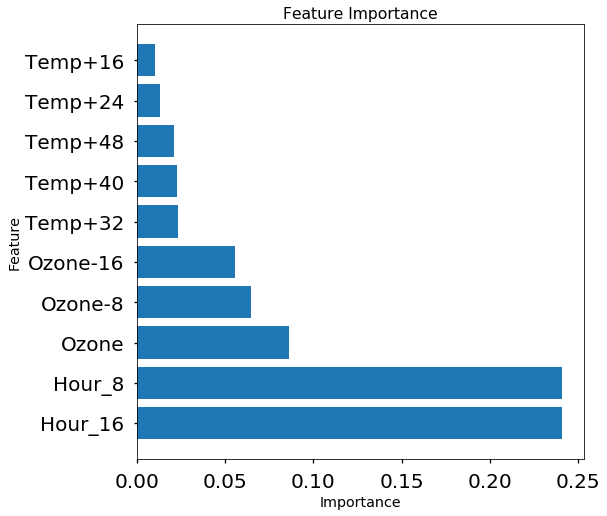

In [161]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.style.use('seaborn-talk')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
ax.barh(df_importance['features'][:10], df_importance['importance'][:10])
ax.set(title = 'Feature Importance',
       xlabel = 'Importance',
      ylabel = 'Feature')
plt.show
#plt.savefig('year_line_plots2.png')

# Test Ridge, Lasso, OLS, and Elastic Net

In [169]:
#test ridge, lasso, and ols

def test(models, X, y, iterations = 100):
    results = {}
    for i in models:
#         r2_train = []
#         r2_test = []
#         for j in range(iterations):
#             X_train, X_test, y_train, y_test = train_test_split(X, 
#                                                                 y, 
#                                                                 test_size= 0.2)
#             r2_test.append(metrics.r2_score(y_test,
#                                             models[i].fit(X_train, 
#                                                          y_train).predict(X_test)))
#             r2_train.append(metrics.r2_score(y_train, 
#                                              models[i].fit(X_train, 
#                                                           y_train).predict(X_train)))
#         results[i] = [np.mean(r2_train), np.mean(r2_test)]
        mse_train = []
        mse_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, 
                                                                test_size= 0.2)
            mse_test.append(mean_squared_error(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            mse_train.append(mean_squared_error(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(mse_train), np.mean(mse_test)]
    return pd.DataFrame(results)


X = df2.drop(['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48'], axis = 1)
X = preprocessing.normalize(X)
y = df2[['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48']]

models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge()}

test(models, X, y)

,OLS,Lasso,Ridge
0,0.000100,0.000395,0.000356
1,0.000106,0.000396,0.000354


In [170]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS': LinearRegression(),
           'Lasso': GridSearchCV(Lasso(), 
                               param_grid=lasso_params).fit(X, y).best_estimator_,
           'Ridge': GridSearchCV(Ridge(), 
                               param_grid=ridge_params).fit(X, y).best_estimator_,}

test(models2, X, y)

//anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
//anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
//anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_

,OLS,Lasso,Ridge
0,0.000100,0.000395,0.000395
1,0.000106,0.000396,0.000395


In [186]:
X = df2.drop(['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48'], axis = 1)
y = df2[['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48']]
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.3, random_state = 21)

enet = ElasticNet(alpha=10)
enet.fit(X_train, y_train)
y_pred_enet = enet.predict(X_test)
mean_squared_error(y_test, y_pred)

0.00023231372575761478

In [111]:
#manually set test/train split with the first 2000 and then last 1000
df2 = pd.read_csv('uncertainty.csv')
df2.rename(columns = {"Unnamed: 0": "Date"}, inplace = True) 
df2 = df2.set_index('Date')
df2.index = pd.to_datetime(df2.index)
df2.dropna(inplace = True) 
df2 = pd.get_dummies(df2, columns = ['Month', 'Hour', 'Day'], drop_first = True)
df2.head(3)

reg = LinearRegression()
X = df2.drop(['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48'], axis = 1)
X_norm = preprocessing.normalize(X)
y = df2[['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48']]
X_train = X[:2000]
X_test = X[2006:3006]
y_train = y[:2000]
y_test = y[2006:3006]

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
cv_results = cross_val_score(reg, X, y, cv = 5)
print(cv_results)
print(r2_score(y_test, y_pred))
mean_squared_error(y_test, y_pred)

[0.68520065 0.66427584 0.72045728 0.65933259 0.71695474]
0.670156754083982


//anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
//anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput=

0.0001112031634564673

In [194]:
#divide data to only have every other day of data, then random test/train split
#the r-squared value goes down a lot, but the MSE stays the same.
#also just decreased the sample size a lot for training

reg = LinearRegression()

safe_split = df2.resample('1D').last()
print(safe_split.shape)

X = safe_split.drop(['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48'], axis = 1)
X_norm = preprocessing.normalize(X)
y = safe_split[['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48']]

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.2, random_state = 21)

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
cv_results = cross_val_score(reg, X, y, cv = 5)
print(cv_results)
print(metrics.r2_score(y_test, y_pred))
metrics.mean_squared_error(y_test, y_pred)

(1002, 69)
[0.3467947  0.46944879 0.39018309 0.49054915 0.44877925]
0.5345551212271223


//anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
//anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput=

0.00010464834322559598

In [198]:
#percentage that RMSE is of the aveage ozone level - 28.5%
(0.000106**0.5)/(df2['Ozone'].mean()) *100

28.509137323071677